## Introduction

This notebook serves as a demonstration of how one might use parallel_plugin.ipynb in a realistic data science scenario - ie. where the notebook uses external files, classes, global functions/variables, and automatic differentiation. 

Consider the problem of bayesian linear regression (cf. Bishop 3.3). We will first learn the mean via metropolis hastings and variational inference.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import optim
import numpy as np
import pandas as pd
from torch.distributions.normal import Normal
import numpy.random as npr
from models import LinRegGuide, Elbo
from helpers import seed_all, linear_regression_data

In [2]:
# Metropolis sampling (symmetric proposal) for given log-target distribution
def mhsample(x0, n, logtarget, drawproposal):
    x = x0
    xs = torch.zeros(x0.shape[0], n)
    accepts = 0
    for i in range(n):
        if (i % 1000) == 0:
            print("Steps: {}".format(i))
        x_prop = drawproposal(x)
        if np.log(npr.rand()) < logtarget(x_prop) - logtarget(x):
            x = x_prop
            accepts += 1
        xs[:, i] = x
    print("Sampler acceptance rate:", accepts/n)
    return xs

In [3]:
offset = 0
N = 1000
D = 2
X, y, w_true = linear_regression_data(N, D, 10)
proposal_std = 0.01

In [4]:
def run_metropolis_hastings(ITERS):
    seed_all(0)
    
    model = LinRegGuide(D)

    target = lambda w: model.mh_target(X, y, w)
    proposal = lambda w: w + proposal_std*torch.randn(D)

    x0 = torch.zeros(D)
    
    xs = mhsample(x0, ITERS, target, proposal)
    
    # Discard the first half of samples as warm-up
    xs = xs[:, xs.shape[1]//2:]
    xs = pd.DataFrame(xs.numpy().T)

    w_hat = xs.mean().values
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE
    
def run_variational_inference(EPOCHS):
    seed_all(0)
    model = LinRegGuide(D)
    criterion = Elbo(model)
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

    for epoch in range(EPOCHS):
        opt.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            print(epoch, loss.item())
            
    w_hat = model.mu.squeeze().detach().numpy()
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE

In [5]:
training_epochs = 20000

w_hat, RMSE = run_metropolis_hastings(training_epochs)
print("The true mean is:", w_true.numpy())
print("The mean learned w/ metropolis hastings is:", w_hat)
print("RMSE:", RMSE)

Steps: 0
Steps: 1000
Steps: 2000
Steps: 3000
Steps: 4000
Steps: 5000
Steps: 6000
Steps: 7000
Steps: 8000
Steps: 9000
Steps: 10000
Steps: 11000
Steps: 12000
Steps: 13000
Steps: 14000
Steps: 15000
Steps: 16000
Steps: 17000
Steps: 18000
Steps: 19000
Sampler acceptance rate: 0.7995
The true mean is: [10.885099  8.121346]
The mean learned w/ metropolis hastings is: [10.872889  8.085914]
RMSE: 0.026500842


In [6]:
training_epochs = 200

w_hat, RMSE = run_variational_inference(training_epochs)
print("The true mean is:", w_true.numpy())
print("The mean learned w/ variational inference is:", w_hat)
print("RMSE:", RMSE)

0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
50 1696.128173828125
60 1527.938232421875
70 1543.9149169921875
80 1573.55859375
90 1533.380615234375
100 1524.203369140625
110 1537.7313232421875
120 1522.780029296875
130 1540.8355712890625
140 1526.2310791015625
150 1524.8560791015625
160 1525.22705078125
170 1528.9388427734375
180 1521.654541015625
190 1524.3226318359375
The true mean is: [10.885099  8.121346]
The mean learned w/ variational inference is: [10.862334  8.09374 ]
RMSE: 0.025301624


## Using parallel_plugin.ipydb

Now, let's say we want to plot RMSE as a function of training iterations. This would normally require we rewrite the above functions and run them sequentially, once for each value of 'training_epoch'. Instead lets see how we can use the parallel_mixin to make this easier.

First, we load the plugin using Jupyter's magic command 'run', and initialize by passing in the names of any external files we need.

In [8]:
%run parallel_plugin.ipynb
init_parallel(['models.py', 'helpers.py'])

Starting multiprocess cluster...
Multiprocess cluster started w/ 4 workers (2 cores each)
Starting multithread cluster...
Multithread cluster started w/ 1 workers (8 cores each)

        Parallel Plugin Loaded. You can now decorate functions with @profile(profile_array) 
        and @parallel(map=True, threads=True, background=False). MyClient and get_results(futures)
        have also been loaded into your namespace.
        


Before running the methods in parallel we first profile them to see what kind of speed up we can expect. Normally one would decorate the existing functions, but for demonstration purposes I'll duplicate the functions below.

The @profile argument takes the range of values you expect to pass in to your parallelized function.  

In [11]:
@profile(range(2000, 20000, 2000))
def run_metropolis_hastings(ITERS):
    seed_all(0)
    
    model = LinRegGuide(D)

    target = lambda w: model.mh_target(X, y, w)
    proposal = lambda w: w + proposal_std*torch.randn(D)

    x0 = torch.zeros(D)
    
    xs = mhsample(x0, ITERS, target, proposal)
    
    # Discard the first half of samples as warm-up
    xs = xs[:, xs.shape[1]//2:]
    xs = pd.DataFrame(xs.numpy().T)

    w_hat = xs.mean().values
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE
    
@profile(range(1, 100, 10))
def run_variational_inference(EPOCHS):
    seed_all(0)
    model = LinRegGuide(D)
    criterion = Elbo(model)
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

    for epoch in range(EPOCHS):
        opt.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            print(epoch, loss.item())
            
    w_hat = model.mu.squeeze().detach().numpy()
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE

We now call the decorated functions without arguments. This takes a little while because we have to first run the sequential version as a baseline:

In [10]:
run_metropolis_hastings()

---------Parallel vs Sequential Profile--------
Function: run_metropolis_hastings
Input length: 9
Input type: <class 'int'>
Timing...
Sequential time: 38.4299s
Multiprocessing time: 22.4877s (~1.7089x speedup, 4 workers, 2 cores/worker)
Multithreading time: 21.9990s (~1.7469x speedup, 1 workers, 8 cores/worker)


In [12]:
run_variational_inference()

---------Parallel vs Sequential Profile--------
Function: run_variational_inference
Input length: 10
Input type: <class 'int'>
Timing...
Sequential time: 0.3236s
Multiprocessing time: 0.5825s (~0.5556x speedup, 4 workers, 2 cores/worker)
Multithreading time: 0.5703s (~0.5675x speedup, 1 workers, 8 cores/worker)


The profiler returns some useful information. We see we get about a 1.5x speedup by parallelizing run_metropolis_hastings() and the difference between threads and processes is negligible (rerunning the profiler confirms this). 

We also see that parallelizing actually hurts performance with run_variational_inference() due to overhead costs.

With this we decide to parallelize the run_metropolis_hastings() function:

In [13]:
@parallel(map=True, background=False)
def run_metropolis_hastings(ITERS):
    seed_all(0)
    
    model = LinRegGuide(D)

    target = lambda w: model.mh_target(X, y, w)
    proposal = lambda w: w + proposal_std*torch.randn(D)

    x0 = torch.zeros(D)
    
    xs = mhsample(x0, ITERS, target, proposal)
    
    # Discard the first half of samples as warm-up
    xs = xs[:, xs.shape[1]//2:]
    xs = pd.DataFrame(xs.numpy().T)

    w_hat = xs.mean().values
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return RMSE, ITERS

def run_variational_inference(EPOCHS):
    seed_all(0)
    model = LinRegGuide(D)
    criterion = Elbo(model)
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

    for epoch in range(EPOCHS):
        opt.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            print(epoch, loss.item())
            
    w_hat = model.mu.squeeze().detach().numpy()
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return RMSE, EPOCHS

By decorating with the map=True flag, the function now accepts a list of values. If we set background=True, the function will run in the background. This is useful if we want to do work in other cells while the job is running. Notice how the functions parallelize in the presence of globally defined variables and functions (something ipyparallel doesn't do)

In [14]:
mh_results = run_metropolis_hastings(range(2000, 20000, 2000))

In [15]:
vi_results = [run_variational_inference(i) for i in range(1, 100, 10)]

0 109298.5703125
0 109298.5703125
10 27935.458984375
0 109298.5703125
10 27935.458984375
20 2408.353515625
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
50 1696.128173828125
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
50 1696.128173828125
60 1527.938232421875
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
50 1696.128173828125
60 1527.938232421875
70 1543.9149169921875
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
50 1696.128173828125
60 1527.938232421875
70 1543.9149169921875
80 1573.55859375
0 109298.5703125
10 27935.458984375
20 2408.353515625
30 3057.296875
40 3071.631591796875
50 1696.128173828125
60 1527.938232421875
70 1543.9149169921875
80 1573.5585

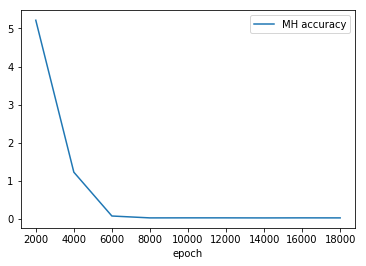

In [16]:
pd.DataFrame(mh_results, columns=['MH accuracy', 'epoch']).set_index('epoch').sort_index().plot()

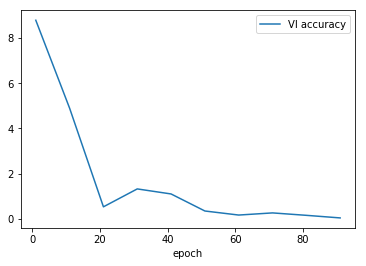

In [17]:
pd.DataFrame(vi_results, columns=['VI accuracy', 'epoch']).set_index('epoch').sort_index().plot()